# CO416 - Machine Learning for Imaging

## Coursework 1 - Classification

In this coursework you will be applying the material taught in the course up to and including lecture 4.

$\mathbf{NOTE - \text{READ THIS}:}$ 
- During this coursework you will be asked to comment on the performance of various aspects of the models you develop. The discussion should be done along the following lines:
    - Maximum 100 words of discussion - You are asked to be brief and on point, platitudes and excessive writing will be penalized
    - You should mention effects on accuracy, and computational requirements i.e. time and computational complexities. Empirical arguments are accepted 
    
- When you are asked to change the hyperparamenters, validate the performance of your classifier and explicitly state the optimal hyperparameters you found and their accuracy

## Question 1 (50 Points) 

In this question we will use a toy spiral dataset as generated by the [`make_moons`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function of sklearn

1) Create a dataset of 1000 points with a noise value of 0.1 and random_state=0 and augment it using polynomial features (recommended degree 10-15) (4 points)

In [1]:
from sklearn import datasets
from sklearn import preprocessing

# create dataset
X, y = datasets.make_moons(n_samples=1000, noise=0.5, random_state=0)

# augment the dataset
poly = preprocessing.PolynomialFeatures(degree=10)
X_poly = poly.fit_transform(X)

2) Visualize your input data - the first 2 dimensions would suffice  (3 points)



In [2]:
from matplotlib import pyplot as plt

l1_x = []
l1_y = []
l2_x = []
l2_y = []
for i, (d1, d2) in enumerate(X):
    (l1_x if y[i] == 0 else l2_x).append(d1)
    (l1_y if y[i] == 0 else l2_y).append(d2)

plt.scatter(l1_x, l1_y, c='red')
plt.scatter(l2_x, l2_y, c='green')
plt.show()

<Figure size 640x480 with 1 Axes>

3) Use a Decision Tree to classify the data (5 points)



In [3]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np

def split_dataset(X, y, split=0.9):
    split_boundary = int(split * len(y))
    train_X, train_y = X_poly[:split_boundary], y[:split_boundary]
    test_X, test_y = X_poly[split_boundary:], y[split_boundary:]
    
    return train_X, train_y, test_X, test_y

def get_model_accuracy(classifier, test_X, test_y):
    unique, counts = np.unique(classifier.predict(test_X) - test_y, return_counts=True)
    counts = dict(zip(unique, counts))
    return counts[0] / float(len(test_X))
    

def train_dt(X, y, criterion="gini", max_depth=None, split=0.9):
    classifier = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, random_state=0)
    
    train_X, train_y, test_X, test_y = split_dataset(X, y, split)
    classifier.fit(train_X, train_y)
    
    # the last two are needed for part 13
    return classifier, get_model_accuracy(classifier, test_X, test_y), test_X, test_y

_, accuracy, _, _ = train_dt(X_poly, y, max_depth=2)

print(f"Accuracy: {accuracy}")

Accuracy: 0.82


4) Try both Gini Impurity and Information Gain, which performs better? What is the difference between them? (4 points)

In [4]:
gini_clf, gini_acc, _, _ = train_dt(X_poly, y, criterion='gini', split=0.9)
print('acc:', gini_acc)

entropy_clf, entropy_acc, _, _ = train_dt(X_poly, y, criterion='entropy', split=0.9)
print('acc:', entropy_acc)

acc: 0.71
acc: 0.74


As shown above, the decision tree with entropy impurity performs better in terms of accuracy.
The difference between them is that information gain requires to compute logarithmic functions 
which are computationally intensive.

5) Perform classification using a tree depth of 1-20. Plot the accuracy versus tree depth. (5 points)



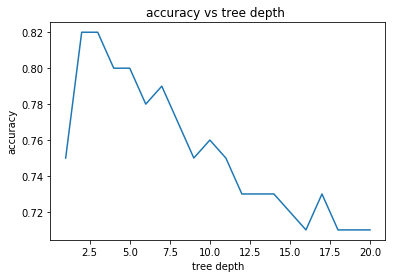

In [5]:
accs = []
depths = list(range(21))[1:]
for depth in depths:
    _, acc, _, _ = train_dt(X_poly, y, max_depth=depth, split=0.9)
    accs.append(acc)

plt.plot(depths, accs)
plt.title('accuracy vs tree depth ')
plt.xlabel('tree depth')
plt.ylabel('accuracy')
plt.show()

6) How does the depth of a tree affect performance and computational burden? (1 points)

As shown above, when depth of the tree increases, the classifier performs better until max depth is 3. However, at some point, the actual accuracy starts to decrese since the classifier tends to overfit. This occurs
since the deep tree learns the given dataset too well, thus, perfectlly fit all samples in the set. Therefore, it 
ends up with branches with strict rules of sparse data. Thus this effects the accuracy when predicting samples 
that are not part of the training set.

7) Use Bootstrap Classifier to classify your data, base estimator should be a decision tree. Tune hyperparameters of tree depth, n_of estimators, max_samples and bootstrap. Plot accuracy versus different hyperparameters. (7 points)



/Users/jha/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy with best found params: 0.82
{'n_estimators': 51, 'max_samples': 0.4746938775510204, 'bootstrap': True, 'base_estimator__max_depth': 2}


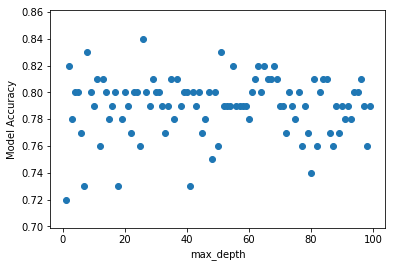

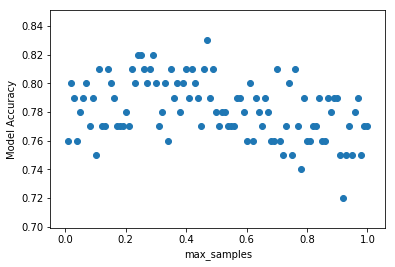

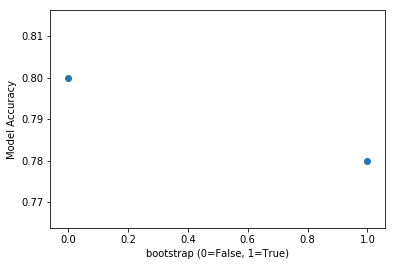

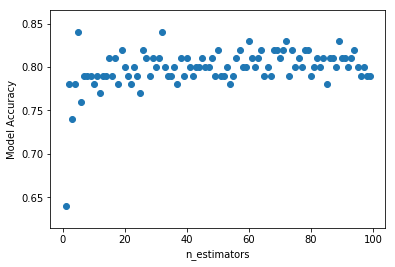

In [6]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV

X_train, y_train, X_test, y_test = split_dataset(X, y, 0.9)


def train_test_bootstrap(max_depth=None, n_estimators=10, max_samples=0.1, bootstrap=True):
    base_classifier = DecisionTreeClassifier(criterion="gini", max_depth=max_depth)
    ensemble = BaggingClassifier(base_estimator=base_classifier,
                                   n_estimators=n_estimators,
                                   max_samples=max_samples,
                                   bootstrap=bootstrap)
    ensemble.fit(X_train, y_train)
    
    return ensemble, get_model_accuracy(ensemble, X_test, y_test)

# TODO: Search over max_depth for base_estimator of BaggingClassifier too. 
# Maybe iterate over some random max_depths and perform param search for each.
# base_estimator__max_depth works better

search_params = {
    "n_estimators": range(1, 100, 5),
    "bootstrap": [True, False],
    "max_samples": np.linspace(0.01, 1., 50),
    "base_estimator__max_depth": range(2, 50, 5)
}    


tuned_bootstrap = RandomizedSearchCV(BaggingClassifier(base_estimator=DecisionTreeClassifier()), search_params, n_iter=100)
tuned_bootstrap.fit(X_train, y_train)

print(f"Accuracy with best found params: {get_model_accuracy(tuned_bootstrap, X_test, y_test)}")
print(tuned_bootstrap.best_params_)

# TODO: Make part below better. Maybe 3D plots showing how parameters are correlated rather than just individual
# plots for each parameter.
# this is god enough I think 

depth_accuracies = [train_test_bootstrap(max_depth=depth)[1] for depth in range(1, 100)]
plt.scatter(range(1, 100), depth_accuracies)
plt.xlabel("max_depth")
plt.ylabel("Model Accuracy")
plt.show()

max_samples = np.linspace(0.01, 1., 100)
sample_accuracies = [train_test_bootstrap(max_samples=ms)[1] for ms in max_samples]
plt.scatter(max_samples, sample_accuracies)
plt.xlabel("max_samples")
plt.ylabel("Model Accuracy")
plt.show()

bootstrap_accuracies = [train_test_bootstrap(bootstrap=True)[1], train_test_bootstrap(bootstrap=False)[1]]
plt.scatter(range(0, 2), bootstrap_accuracies)
plt.xlabel("bootstrap (0=False, 1=True)")
plt.ylabel("Model Accuracy")
plt.show()

estimators_accuracies = [train_test_bootstrap(n_estimators=e)[1] for e in range(1, 100)]
plt.scatter(range(1, 100), estimators_accuracies)
plt.xlabel("n_estimators")
plt.ylabel("Model Accuracy")
plt.show()

8) Why do we use Bootstraping when we create our datasets? Did you use replacement ? Why ? (1 points) 

Bootstrapping, or sampling with replacement, allows us to approximate the distribution of our full population
while training multiple learners. By training different models by using data acquired through random sampling with 
replacement of our original data, each model will be trained on a different subset of the data. 
This means that each model will be somewhat independant of other models, but should still approximate our original
distribution; this allows us to build an ensemble model using our individual learners. If we did not use replacement,
we may not approximate the original distribution with our ensemble.

9)  Use a Decision Forest to classify the new dataset (4 points)



In [7]:
from sklearn.ensemble import RandomForestClassifier

# classify data using a RandomForestClassifier
def train_rt(X, y, n_estimators=10, max_depth=None, split=0.9):
    # create the classifier
    classifier = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    
    # split the dataset
    train_X, train_y, test_X, test_y = split_dataset(X, y, split)
    classifier.fit(train_X, train_y)
    return classifier, get_model_accuracy(classifier, test_X, test_y), test_X, test_y

_, accuracy, _, _ = train_rt(X_poly, y)

print('accuracy:', accuracy)

accuracy: 0.73


10) Modulate the number of trees to 1-99 with a step of 10. Plot accuracy versus number of trees. (4 points)



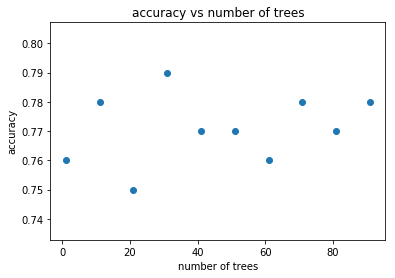

In [8]:
accs = []
nb_trees = list(range(1, 99, 10))
optimal_no = (0, 0)
for nb_tree in nb_trees:
    _, acc, _, _ = train_rt(X_poly, y, n_estimators=nb_tree)
    packed = (float(acc), nb_tree)
    optimal_no = max(packed, optimal_no)
    accs.append(float(acc))

plt.close()
plt.scatter(nb_trees, accs)
plt.title('accuracy vs number of trees')
plt.xlabel('number of trees')
plt.ylabel('accuracy')
plt.show()

11) Modulate the depth of  the trees from 1 to 20 - use best number of trees from above. Plot the accuracy versus depth. (4 points)



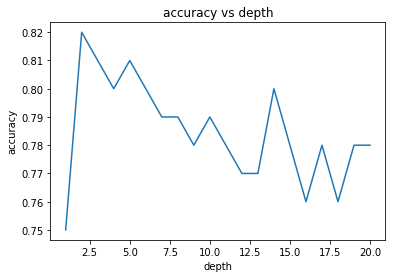

In [9]:
accs = []
tree_depths = list(range(1, 21))
for tree_depth in tree_depths:
#     optimal_no is a tuple with best (accuracy, no of trees) found in previous Q
    _, acc, _, _ = train_rt(X_poly, y, n_estimators=optimal_no[1], max_depth=tree_depth)
    accs.append(float(acc))

plt.plot(tree_depths, accs)
plt.title('accuracy vs depth')
plt.xlabel('depth')
plt.ylabel('accuracy')
plt.show()

12) Comment on the performance change while you modulate depth of trees and number of trees (3 points)


When modulating the tree depth, as the depth increases, the performance tends to be better in terms of accuracy.
However, at some point, the accuracy becomes lower due to overfitting as mentioned before in 6).

When modulating the number of trees, as the number of trees increases, the performance tends to be better in terms of 
accuracy. Generally, the results get better as more trees are involved in the forest. However, the improvement rate
decreases as the number of trees increases. Thie implies that at some point, the benefit in prediction will be lower 
than its computation cost (i.e. time).


13) Visualise how the classification split is done in relation to the data both for Decision Tree and Decision Forest (3 points)

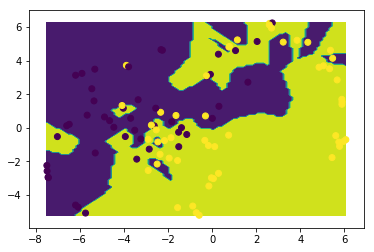

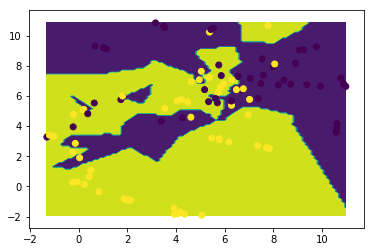

In [10]:
## ADD YOUR CODE HERE

from sklearn.manifold.t_sne import TSNE
from sklearn.neighbors.classification import KNeighborsClassifier

def plot_decision_boundary(model,X,y):
    Y_pred=model.predict(X)
    X_Train_embedded = TSNE(n_components=2).fit_transform(X)
    
    # create meshgrid
    resolution = 100
    X2d_xmin, X2d_xmax = np.min(X_Train_embedded[:,0]), np.max(X_Train_embedded[:,0])
    X2d_ymin, X2d_ymax = np.min(X_Train_embedded[:,1]), np.max(X_Train_embedded[:,1])
    xx, yy = np.meshgrid(np.linspace(X2d_xmin, X2d_xmax, resolution), np.linspace(X2d_ymin, X2d_ymax, resolution))

    # approximate Voronoi tesselation on resolution x resolution grid using 1-NN
    background_model = KNeighborsClassifier(n_neighbors=1).fit(X_Train_embedded, Y_pred) 
    voronoiBackground = background_model.predict(np.c_[xx.ravel(), yy.ravel()])
    voronoiBackground = voronoiBackground.reshape((resolution, resolution))

    # plot
    plt.contourf(xx, yy, voronoiBackground)
    plt.scatter(X_Train_embedded[:,0], X_Train_embedded[:,1], c=y)
    plt.show()

# Decision Tree
tree_model, tree_acc, tree_test_X, tree_test_y = train_dt(X_poly, y)
plot_decision_boundary(tree_model, tree_test_X, tree_test_y)

# Decision Forest
forest_model, forest_acc, forest_test_X, forest_test_y = train_rt(X_poly, y)
plot_decision_boundary(forest_model, forest_test_X, forest_test_y)

## Question 2 (50 Points)
In this question we will be using the fashion-MNIST dataset for image classification. 

If you are interested, you may find relevant information regarding the dataset in this paper:
Fashion-MNIST: A novel image dataset for benchmarking machine learning algorithms. Han Xiao, Kashif Rasul, Roland Vollgraf. [arXiv:1708.07747](https://arxiv.org/abs/1708.07747)

The data is provided under `/vol/lab/course/416/data/fashion`. The dataset is already split into a set of 60,000 training images and a set of 10,000 test images. The images are of size 28x28 pixels and stored as 784-dimensional vector. So if you would like to visualise the images, you need to reshape the array.

There are in total 10 classes, which are labelled as follows:
0. T-shirt/top
1. Trousers
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot

**Your tasks are** (all tasks carry equal marks):
- Use a Decision Forest to classify t-shirts and ankle boots - tune your forest!
- Train and compare an Adaboost classifier with a decision tree 
- Modulate the number of trees in the Adaboost and the depth of the trees. Comment on the performance and complexity 
- Train a Decsiion Forest for all classes and also compare the performance with another ensemble algorithm of your choice
- What is the theoretical difference between Random Forests and Adaboost classifiers? (100 words max)

In [11]:
# load the data
import numpy as np
import pandas as pd

data_dir = './data/fashion/'

df_train = pd.read_csv(data_dir + 'fashion_mnist_train.csv')
df_test = pd.read_csv(data_dir + 'fashion_mnist_test.csv')

x_train = df_train.drop('label', axis=1).as_matrix().astype(np.uint8)
y_train = df_train['label'].as_matrix().astype(np.uint8)
x_test = df_test.drop('label', axis=1).as_matrix().astype(np.uint8)
y_test = df_test['label'].as_matrix().astype(np.uint8)

/Users/jha/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
/Users/jha/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/Users/jha/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
/Users/jha/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]


In [12]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

def train_adaboost(X, y, n_estimators=3, max_depth=None):
    base_classifier = DecisionTreeClassifier(max_depth=max_depth)
    classifier = AdaBoostClassifier(base_estimator=base_classifier, 
                                    n_estimators=n_estimators)
    classifier.fit(X, y)
    
    return classifier

def train_dt(X, y, max_depth=None):
    classifier = DecisionTreeClassifier(criterion="gini", max_depth=max_depth)
    classifier.fit(X, y)
    return classifier

def train_bootstrap(X, y, max_depth=None, n_estimators=10, max_samples=0.1, bootstrap=True):
    base_classifier = DecisionTreeClassifier(criterion="gini", max_depth=max_depth)
    ensemble = BaggingClassifier(base_estimator=base_classifier,
                                   n_estimators=n_estimators,
                                   max_samples=max_samples,
                                   bootstrap=bootstrap)
    ensemble.fit(X, y)
    
    return ensemble

# Change labels: 0: t-shirt, 1: ankle boot, 2: other
t_shirt, ankle = 0, 9
y_train_new = [0 if label == t_shirt else (1 if label == ankle else 2) for label in y_train]
y_test_new = [0 if label == t_shirt else (1 if label == ankle else 2) for label in y_test]

# ================ Part 1 ================
search_params = {
    "n_estimators": range(1, 20),
    "max_depth": range(1, 20)
}
tuned_rf = RandomizedSearchCV(RandomForestClassifier(), search_params, n_iter=10, cv=5)
tuned_rf.fit(x_train, y_train_new)
print(tuned_rf.best_params_)

print(f"Part 1- Decision Forest Accuracy: {get_model_accuracy(tuned_rf, x_test, y_test_new)}")



{'n_estimators': 18, 'max_depth': 18}
Part 1- Decision Forest Accuracy: 0.9528


In [13]:
# ================ Part 2 ================

ada_params = {
    "n_estimators": range(1, 50)
}
tuned_ada = RandomizedSearchCV(AdaBoostClassifier(), ada_params)
tuned_ada.fit(x_train, y_train_new)

dt_params = {
    "max_depth": range(1, 50)
}
tuned_dt = RandomizedSearchCV(DecisionTreeClassifier(), dt_params)
tuned_dt.fit(x_train, y_train_new)

print(f"Part 2- \nAdaboost Accuracy: {get_model_accuracy(tuned_ada, x_test, y_test_new)}\nDecision Tree Accuracy: \
      {get_model_accuracy(tuned_dt, x_test, y_test_new)}")

'''
TODO: Comment on this. Maybe also note which params work best.
'''

/Users/jha/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/jha/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Part 2- 
Adaboost Accuracy: 0.8449
Decision Tree Accuracy:       0.9255


'\nTODO: Comment on this. Maybe also note which params work best.\n'

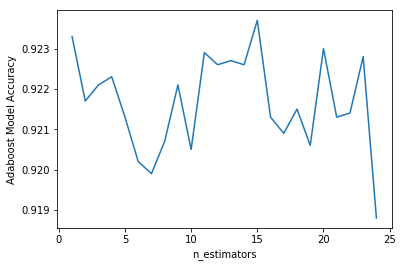

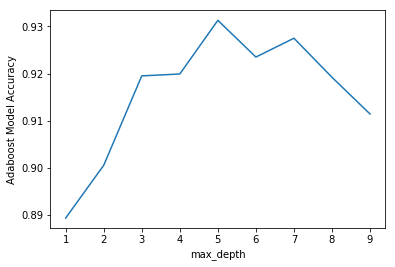

'\nTODO: Comment on results\n'

In [15]:
# ================ Part 3 ================
# TODO: Improve. Use RandomizedSearchCV to find best parameters. Also maybe look at compute time based on params.
classifiers = [train_adaboost(x_train, y_train_new, n_estimators=e) for e in range(1, 25)]
plt.plot(range(1, 25), [get_model_accuracy(c, x_test, y_test_new) for c in classifiers])
plt.xlabel("n_estimators")
plt.ylabel("Adaboost Model Accuracy")
plt.show()

classifiers = [train_adaboost(x_train, y_train_new, max_depth=d) for d in range(1, 10)]
plt.plot(range(1, 10), [get_model_accuracy(c, x_test, y_test_new) for c in classifiers])
plt.xlabel("max_depth")
plt.ylabel("Adaboost Model Accuracy")
plt.show()

'''
TODO: Comment on results
'''

In [16]:
# ================ Part 4 ================
# Train a Decsiion Forest for all classes and also compare the performance with 
# another ensemble algorithm of your choice

# TODO: Tune + compare
rf_all = train_random_forest(x_train, y_train, n_estimators=10)
adabost_all = train_adaboost(x_train, y_train)

print(f"Part 4- \nRandom Forest Accuracy: {get_model_accuracy(rf_all, x_test, y_test)}\nBootstrap Accuracy: \
      {get_model_accuracy(adabost_all, x_test, y_test)}")


NameError: name 'train_random_forest' is not defined

In [18]:
# ================ Part 5 ================

'''
They are ensemble methods, Random Forest (RF) is paralell and AdaBoost (AB) is a sequential algorithm. 
In parallel ensemble methods, many independent base learners are trained simultaneously and then combined to predict.
The combines prediction learnt from multiple models run independently averaging away impact of isolated errors. 
Thus reduces variance of the prediction.
In sequential ensemble methods, base (ML) learners are added one at a time and mislabelled examples are upweighted 
each time. It exploits the dependence between base learners – thus learning a complementary set of predictors that 
reduce the bias and increase the accuracy.
'''

'\nThey are ensemble methods, Random Forest (RF) is paralell and AdaBoost (AB) is a sequential algorithm. \nIn parallel ensemble methods, many independent base learners are trained simultaneously and then combined to predict.\nThe combines prediction learnt from multiple models run independently averaging away impact of isolated errors. \nThus reduces variance of the prediction.\nIn sequential ensemble methods, base (ML) learners are added one at a time and mislabelled examples are upweighted \neach time. It exploits the dependence between base learners – thus learning a complementary set of predictors that \nreduce the bias and increase the accuracy.\n'